# Example: MNIST with NICE

2020-11-18 first created

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from _nice import *
from utils import *
import tensorflow as tf
# import tensorflow_probability as tfp
# from utils import *
tfk = tf.keras
# tfkl = tfk.layers
# tfkc = tfk.callbacks
# tfd = tfp.distributions
# K = tfk.backend
mnist = tfk.datasets.mnist

print(tf.__version__)
!python --version

2.3.1
Python 3.7.6


## Settings

In [2]:
inp_dim = 784
n_couple_layer = 5
n_hid_layer = 5
n_hid_dim = 512
shuffle_type = 'reverse'
n_batch = 128
n_epoch = 10000
n_display = 1000

In [3]:
(x_train, y_train), (_, _) = mnist.load_data()

img_h, img_w = x_train.shape[1:]
inp_dim = img_h * img_w

x_train = x_train.reshape([-1, inp_dim]).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = tf.data.Dataset.zip((dataset, dataset))
dataset = dataset.repeat().shuffle(x_train.shape[0]).batch(n_batch, drop_remainder=True)

## Initialize the model

In [4]:
model = NICE(inp_dim, shuffle_type, n_couple_layer, n_hid_layer, n_hid_dim, name='NICE')
model.build(input_shape=(inp_dim,))
model.summary()

Model: "NICE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer0 (AdditiveCouplingLaye multiple                  1453720   
_________________________________________________________________
Layer1 (AdditiveCouplingLaye multiple                  1453720   
_________________________________________________________________
Layer2 (AdditiveCouplingLaye multiple                  1453720   
_________________________________________________________________
Layer3 (AdditiveCouplingLaye multiple                  1453720   
_________________________________________________________________
Layer4 (AdditiveCouplingLaye multiple                  1453720   
_________________________________________________________________
scaling_layer (ScalingLayer) multiple                  784       
Total params: 7,269,384
Trainable params: 7,265,464
Non-trainable params: 3,920
________________________________________________

In [5]:
def loss_fun(y_true, y_pred):
    # negative log likelihood
    return tf.math.reduce_sum(0.5 * y_pred **2, axis=1)

model.compile(loss=loss_fun, optimizer='adam')

## Train the model

In [6]:
%%time 
logger = NBatchLogger(n_display, n_epoch)
hist = model.fit(dataset,
                 epochs=n_epoch,
                 steps_per_epoch=1,
                 callbacks=[logger], 
                 verbose=0)

=== Started at 2020-11-22 05h:41m:27s ===
 2020-11-22 05h:41m:30s | Epoch: 1/10000 | loss=46.492825
 2020-11-22 05h:42m:12s | Epoch: 1000/10000 | loss=-746.030457
 2020-11-22 05h:42m:54s | Epoch: 2000/10000 | loss=-1325.766602
 2020-11-22 05h:43m:36s | Epoch: 3000/10000 | loss=-1631.360962
 2020-11-22 05h:44m:18s | Epoch: 4000/10000 | loss=-1856.432495
 2020-11-22 05h:45m:01s | Epoch: 5000/10000 | loss=-1965.746826
 2020-11-22 05h:45m:43s | Epoch: 6000/10000 | loss=-2125.006104
 2020-11-22 05h:46m:25s | Epoch: 7000/10000 | loss=-2233.265381
 2020-11-22 05h:47m:07s | Epoch: 8000/10000 | loss=-2236.015381
 2020-11-22 05h:47m:49s | Epoch: 9000/10000 | loss=-2272.280273
 2020-11-22 05h:48m:32s | Epoch: 10000/10000 | loss=-2261.238281
=== Time elapsed: 7.0811 min (loss:-2261.238281) ===
CPU times: user 37min 34s, sys: 1min 50s, total: 39min 25s
Wall time: 7min 4s


## Check results

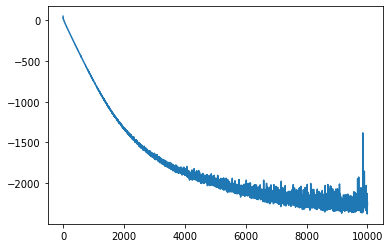

In [7]:
plt.plot(hist.history['loss'])

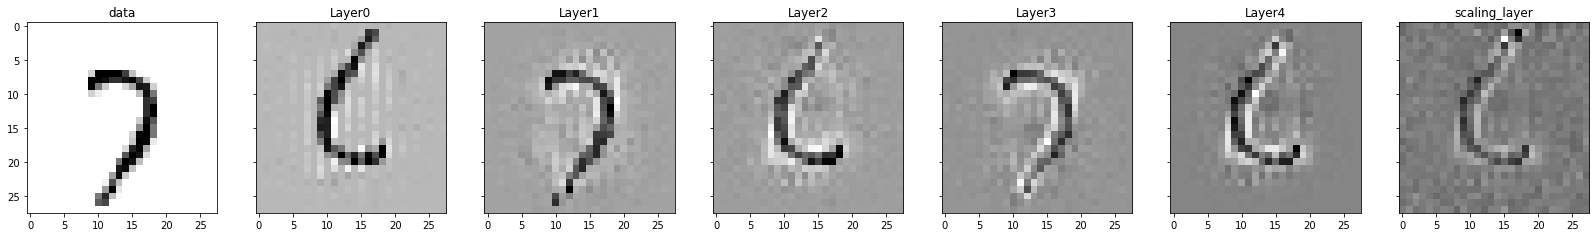

In [10]:
visualize_mnist_layers(model, dataset, direction='forward');

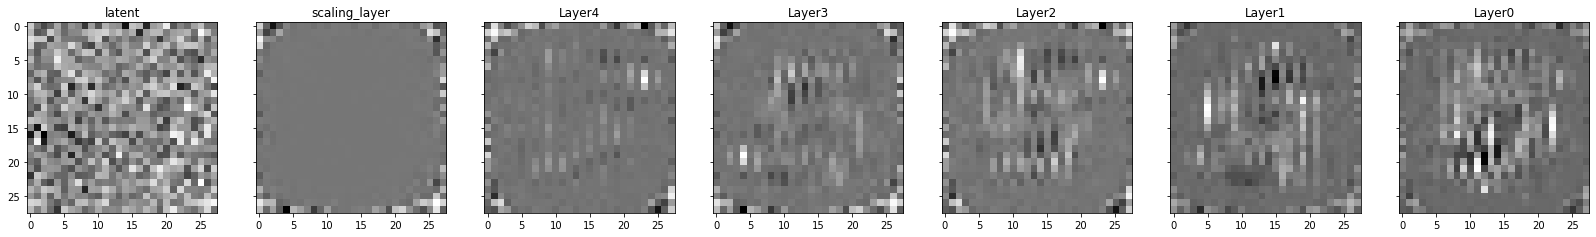

In [11]:
visualize_mnist_layers(model, dataset, direction='inverse');

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.array(np.random.randn(1, inp_dim)) * 0.75 # std=.75 instead of 1
        x_decoded = model.inverse(z_sample).numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


figure = np.clip(figure*255, 0, 255)
fig, ax = plt.subplots(1, figsize=(8,6), facecolor='white')
ax.imshow(figure, aspect='auto', cmap='gray')